In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached lightning-2.5.0.post0-py3-none-any.whl.metadata (40 kB)
  Using cached lightning_utilities-0.12.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached torchmetrics-1.6.1-py3-none-any.whl.metadata (21 kB)
  Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl.metadata (21 kB)
  Using cached aiohappyeyeballs-2.4.6-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
Using cached lightning-2.5.0.post0-py3-none-any.whl (815 kB)
Using cached lightning_utilities-0.12.0-py3-none-any.whl (28 kB)
Using cached torchmetrics-1.6.1-py3-none-any.whl (927 kB)
Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl (819 kB)
Using cached aiohappyeyeballs-2.4.6-py3-none-any.whl (14 kB)
Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)


In [2]:
base_dir: bool = False

In [3]:
import os, sys

if not base_dir:
    os.chdir('../')
    base_dir = True

import numpy as np, pandas as pd, matplotlib.pyplot as plt, sklearn, torch

from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn

from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

from utils.data_tools import inbreast, cbis_ddsm, image_processing
from utils.models import models

import tensorflow as tf

In [4]:
inbreast.download()
cbis_ddsm.download()

Path already exists for INBreast!
Path already exists for CBIS-DDSM!


In [5]:
# Testing Data

class test_data:

    class inbreast_data:

        gen = inbreast.image_batch(compress=True, image_scale='Normalize', to_rgb=True)

        data = next(gen)

No Dataframe provided, loading!


In [6]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.__len__()

    def __getitem__(self, idx):

        image = torch.tensor(np.expand_dims(self.x[idx], axis=0), dtype=torch.float32)
        label = torch.tensor([1, 0] if self.y.iloc[idx] == 'MLO' else [0, 1], dtype=torch.float32)

        return image, label

def get_loader(x, y, batch_size=32):

    loader = DataLoader(CustomImageDataset(x, y), batch_size=batch_size, shuffle=True)

    return loader

In [7]:
l = get_loader(test_data.inbreast_data.data[1], test_data.inbreast_data.data[0]['View'])

In [8]:
for data in l:

    d = data
    break

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class CNNModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=8, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=8, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=8, stride=1, padding=1)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return F.softmax(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        print(f'Train Crossentropy', loss.item())
        return loss
    
    def val_dataloader(self):
        pass
    
    def validation_step(self, batch, batch_idx):
        # Forward pass
        inputs, targets = batch
        outputs = self(inputs)
        
        # Compute loss
        loss = F.cross_entropy(outputs, targets)
        
        # Log validation loss
        print(f'Val Crossentropy', loss.item())
        self.log('val_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        # Custom prediction logic
        x, y = batch  # Adjust based on how your DataLoader returns data
        logits = self.forward(x)
        predictions = F.softmax(logits, dim=-1)
        return predictions

    # def train_dataloader(self):
    #     return self.data

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


Pixel Distribution: shape torch.Size([224, 224, 1]), mean 0.222368, std 0.318515, min 0.000000, max 1.000000, unique 1528


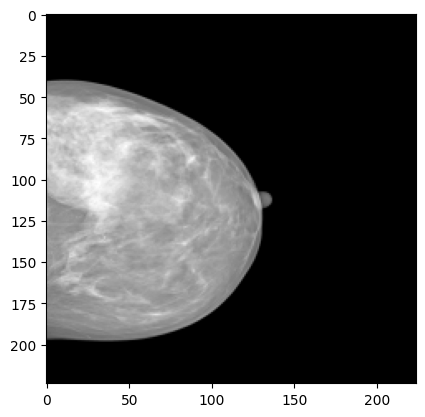

In [33]:
img = d[0][0].permute(1,2,0)

print(
    f"Pixel Distribution: shape {img.shape}, mean {torch.mean(img):2f}, std {torch.std(img):2f}, min {torch.min(img):2f}, max {torch.max(img):2f}, unique {torch.unique(img.flatten()).shape[0]}"
)

plt.imshow(
    img,
    cmap='gray',
)

torch.Size([1, 1, 224, 224])


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Theon\AppData\Local\Temp\ipykernel_28132\1553818884.py:10: SyntaxWarning: invalid escape sequence '\m'
  model.load_state_dict(torch.load('models\model_weights.pt', weights_only=True))
C:\Users\Theon\AppData\Local\Temp\ipykernel_28132\3031963450.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


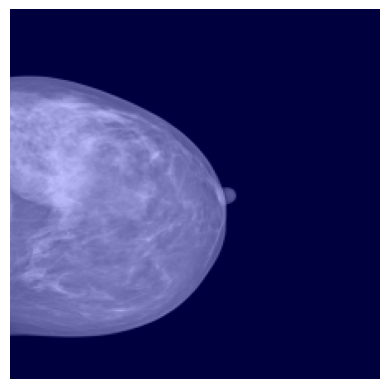

tensor([[1.0000e+00, 5.8541e-19]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


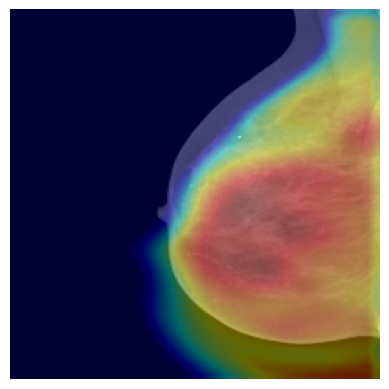

tensor([[0.0057, 0.9943]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


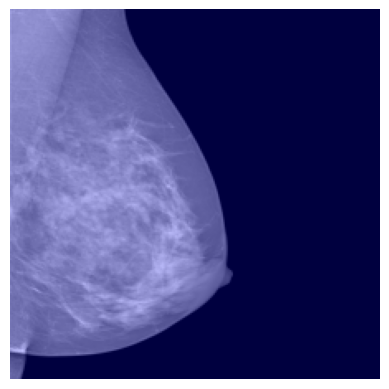

tensor([[1.3522e-19, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


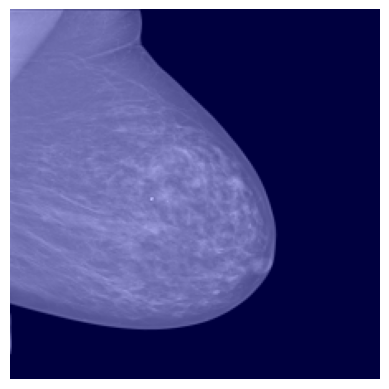

tensor([[3.5960e-26, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


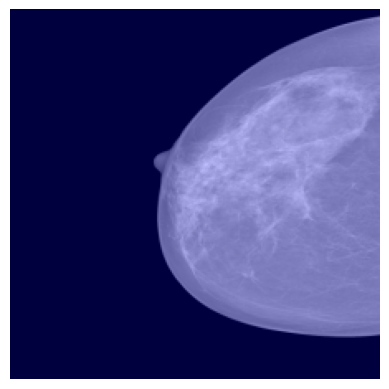

tensor([[1.0000e+00, 5.5643e-17]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


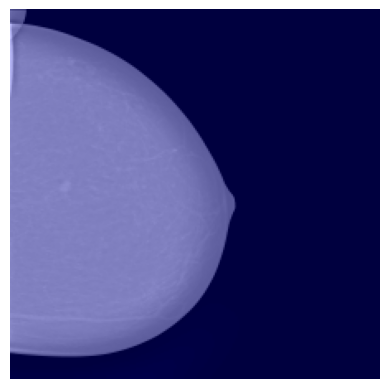

tensor([[1.0000e+00, 1.5123e-14]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


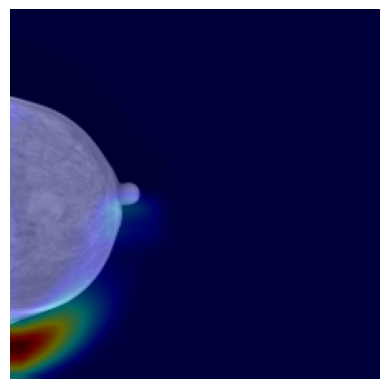

tensor([[1.0000e+00, 4.3054e-10]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


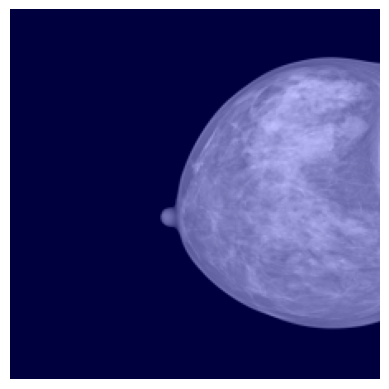

tensor([[1.0000e+00, 8.9145e-26]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


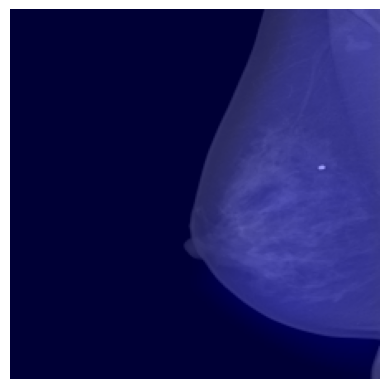

tensor([[3.2656e-13, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


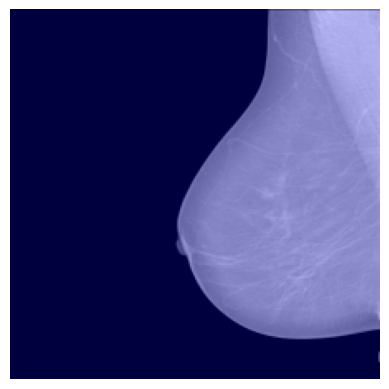

tensor([[1.0483e-32, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


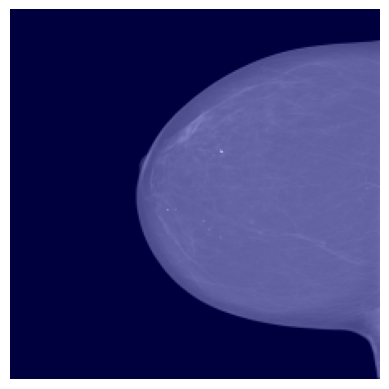

tensor([[1.0000e+00, 9.3774e-17]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


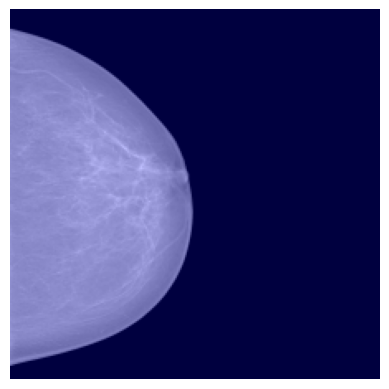

tensor([[1.0000e+00, 5.5718e-20]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


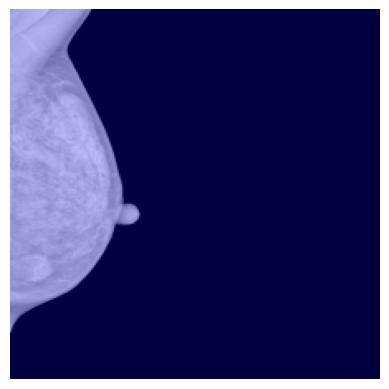

tensor([[9.5268e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


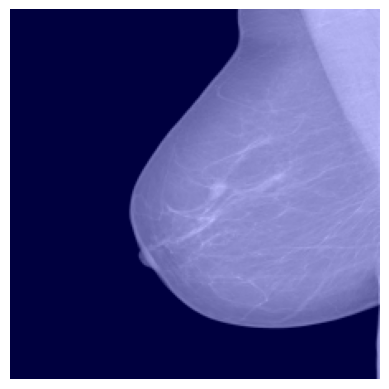

tensor([[8.8100e-36, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


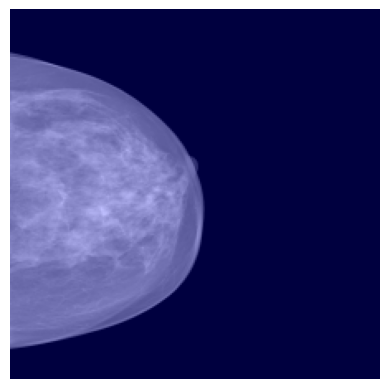

tensor([[1.0000e+00, 2.2507e-18]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 1, 224, 224])


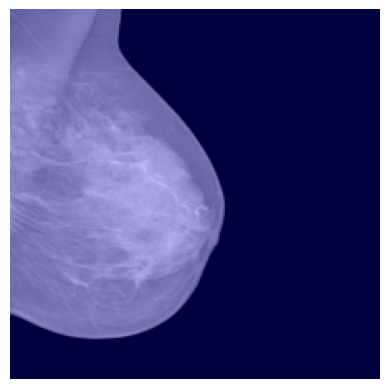

tensor([[8.6677e-19, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

model = CNNModel()

model.load_state_dict(torch.load('models\model_weights.pt', weights_only=True))

model.eval()

target_layer = model.conv3

for i in range(16):

    cam = GradCAM(model=model, target_layers=[target_layer])

    targets = [ClassifierOutputTarget(1)]

    img = d[0][i]

    # Generate CAM
    img = torch.unsqueeze(img, 0)
    print(img.shape)
    grayscale_cam = cam(input_tensor=img, targets=targets)[0]  # [0] to get the first image in the batch

    # Convert image and CAM to numpy arrays
    rgb_img = np.array(img)
    cam_image = show_cam_on_image(np.stack(3*[rgb_img.reshape((224,224))], axis=-1).reshape((224,224,3)), grayscale_cam * 1, use_rgb=True, image_weight=0.6)

    # Display the image
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

    print(model(img))